In [42]:
import h5py
import glob
import numpy as np
from util import plot
from util.atlas import Atlas
import matplotlib.pyplot as plt

from himalaya.scoring import correlation_score

In [2]:
%cd ..

/scratch/gpfs/zzada/narrative-gradients


In [13]:
atlas = Atlas.schaefer(parcels=1000, networks=17, kong=True)

In [27]:
narrative = 'forgot'
narrative = 'black'

modelname = 'acoustic'
modelname = 'syntactic'
modelname = 'articulatory'
modelname = 'gemma-2b'

narratives = ['black', 'forgot']
models = ['acoustic', 'articulatory', 'syntactic', 'gemma-2b']

layer = 16

In [73]:
def get_scores(modelname: str, foldername:str='encoding'):
    files = glob.glob(f'results/{foldername}/sub-*/{modelname}/*h5')

    black_scores = []
    forgot_scores = []
    for filename in files:
        with h5py.File(filename, 'r') as f:
            black_scores.append(f['black_scores'][-1])
            forgot_scores.append(f['forgot_scores'][-1])
    black_scores = np.stack(black_scores)
    forgot_scores = np.stack(forgot_scores)
    
    return black_scores, forgot_scores

## model performance

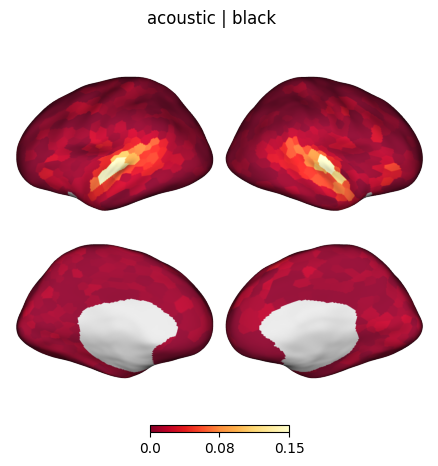

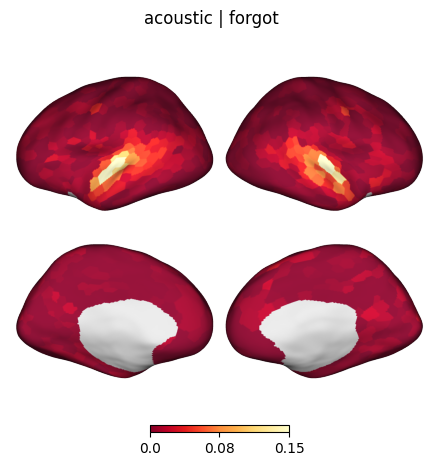

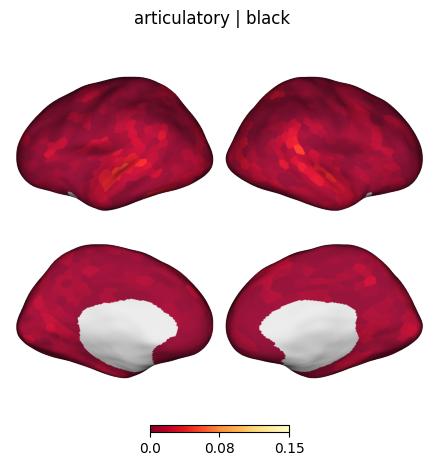

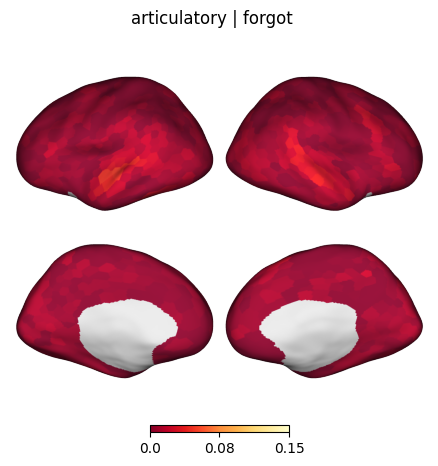

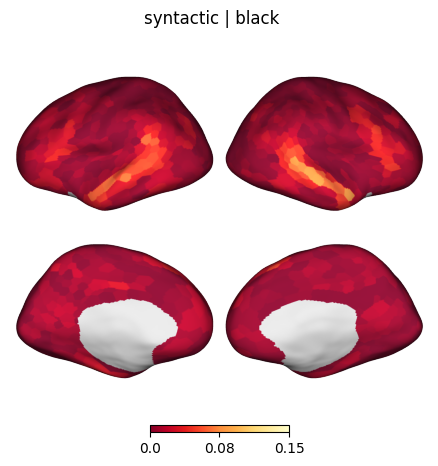

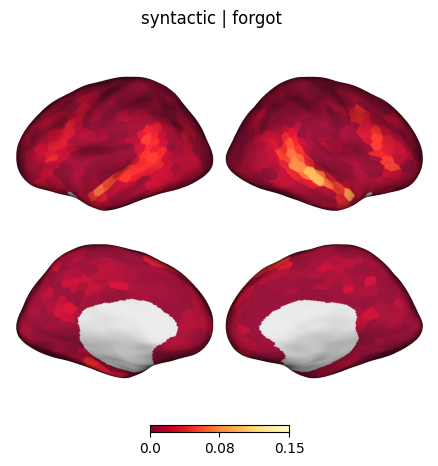

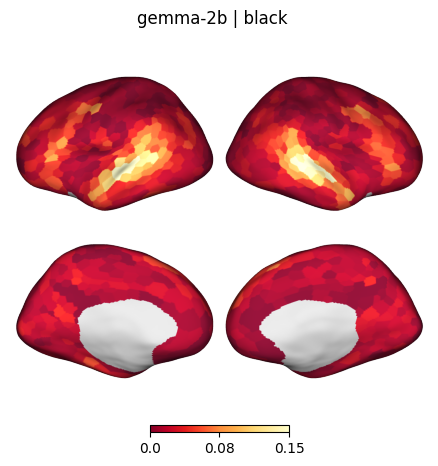

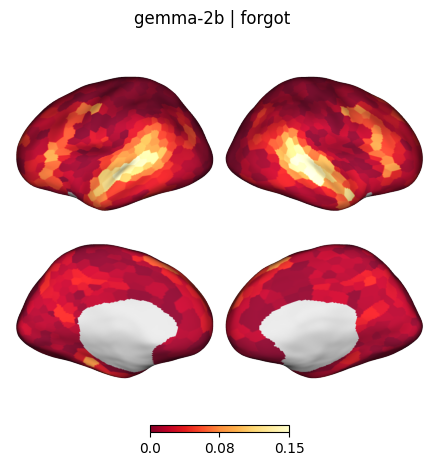

In [30]:
vmax = 0.15

for modelname in models:
    black_scores, forgot_scores = get_scores(modelname)

    values = black_scores.mean(0)
    fig = plot.surface_plot(atlas.parc_to_vox(values), cmap='YlOrRd_r', vmin=0, vmax=vmax, title=f'{modelname} | black')
    fig.show()

    values = forgot_scores.mean(0)
    fig = plot.surface_plot(atlas.parc_to_vox(values), cmap='YlOrRd_r', vmin=0, vmax=vmax, title=f'{modelname} | forgot')
    fig.show()

# model residuals

In [53]:
modelname = 'gemma-2b'

files = glob.glob(f'results/encoding/sub-*/{modelname}/*h5')

black_residuals = []
forgot_residuals = []
for filename in files:
    with h5py.File(filename, 'r') as f:
        black_residuals.append(f['black_actual'][...] - f['black_preds'][...].sum(0))
        forgot_residuals.append(f['forgot_actual'][...] - f['forgot_preds'][...].sum(0))

black_residuals = np.stack(black_residuals)
forgot_residuals = np.stack(forgot_residuals)
black_residuals.shape

(46, 534, 1000)

## compute ISC on residuals

In [58]:
residual_iscs = []

n_sub = len(black_residuals)
for i in range(n_sub):
    others = list(range(n_sub))
    others.remove(i)

    # residuals = black_residuals
    residuals = forgot_residuals

    sub_bold = residuals[i]
    other_bold = residuals[others].mean(0)

    scores = correlation_score(sub_bold, other_bold)
    residual_iscs.append(scores)

residual_iscs = np.stack(residual_iscs)
residual_iscs.shape

(46, 1000)

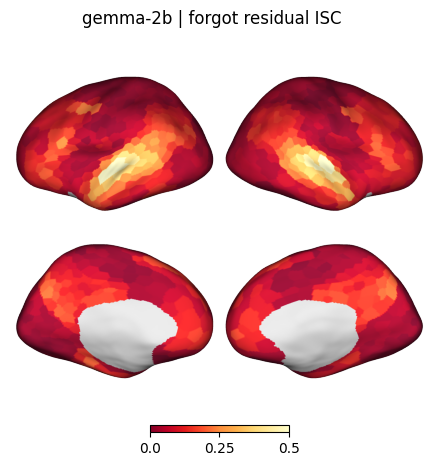

In [59]:
values = residual_iscs.mean(0)

fig = plot.surface_plot(atlas.parc_to_vox(values), cmap='YlOrRd_r', vmin=0, vmax=None, title=f'{modelname} | forgot residual ISC')
fig.show()

## compute residual based on group average predicted time series

In [69]:
modelname = 'gemma-2b'

files = glob.glob(f'results/encoding/sub-*/{modelname}/*h5')

black_groupavg = []
forgot_groupavg = []
for filename in files:
    with h5py.File(filename, 'r') as f:
        black_groupavg.append(f['black_preds'][...].sum(0))
        forgot_groupavg.append(f['forgot_preds'][...].sum(0))

black_groupavg = np.stack(black_groupavg).mean(0)
forgot_groupavg = np.stack(forgot_groupavg).mean(0)
black_groupavg.shape

(534, 1000)

In [70]:
black_residuals = []
forgot_residuals = []
for filename in files:
    with h5py.File(filename, 'r') as f:
        black_residuals.append(f['black_actual'][...] - black_groupavg)
        forgot_residuals.append(f['forgot_actual'][...] - forgot_groupavg)

black_residuals = np.stack(black_residuals)
forgot_residuals = np.stack(forgot_residuals)
black_residuals.shape

(46, 534, 1000)

In [71]:
residuals = black_residuals
residuals = forgot_residuals

residual_iscs = []

n_sub = len(residuals)
for i in range(n_sub):
    others = list(range(n_sub))
    others.remove(i)

    sub_bold = residuals[i]
    other_bold = residuals[others].mean(0)

    scores = correlation_score(sub_bold, other_bold)
    residual_iscs.append(scores)

residual_iscs = np.stack(residual_iscs)
residual_iscs.shape

(46, 1000)

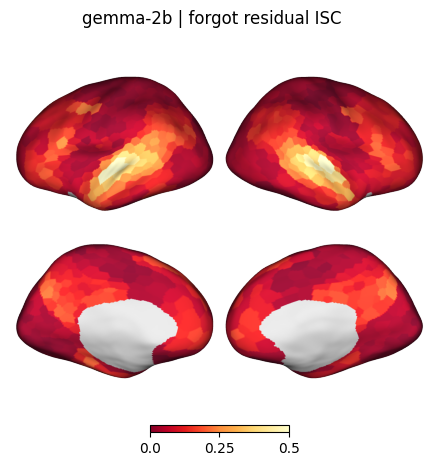

In [72]:
values = residual_iscs.mean(0)

fig = plot.surface_plot(atlas.parc_to_vox(values), cmap='YlOrRd_r', vmin=0, vmax=None, title=f'{modelname} | forgot residual ISC')
fig.show()

# shifted model

In [74]:
black_scores, forgot_scores = get_scores('gemma-2b', foldername='encoding_shifted')

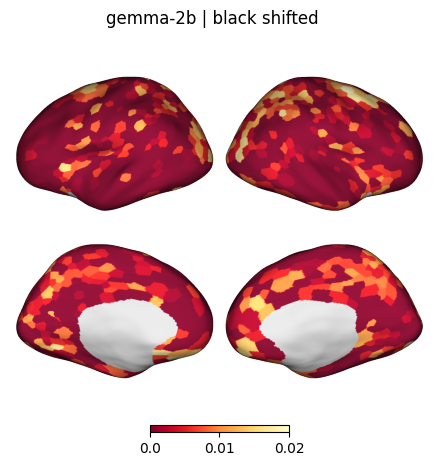

In [76]:
values = black_scores.mean(0)

fig = plot.surface_plot(atlas.parc_to_vox(values), cmap='YlOrRd_r', vmin=0, vmax=None, title=f'{modelname} | black shifted')
fig.show()

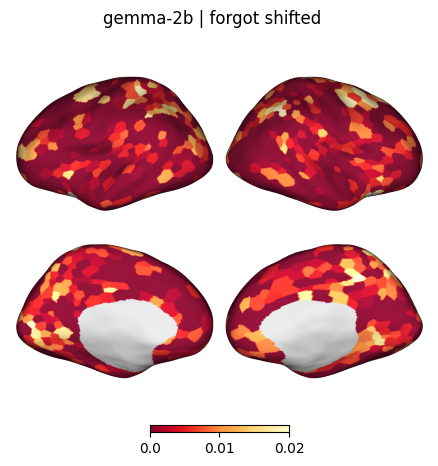

In [77]:
values = forgot_scores.mean(0)

fig = plot.surface_plot(atlas.parc_to_vox(values), cmap='YlOrRd_r', vmin=0, vmax=None, title=f'{modelname} | forgot shifted')
fig.show()

# within subject, 2 fold 

In [14]:
files = glob.glob(f'encoding_2fold/{narrative}/sub-*/model-gemma-2b_layer-{layer}/*h5')

scores = []
for filename in files:
    with h5py.File(filename, 'r') as f:
        cv_scores = f['cv_scores'][...]
        scores.append(cv_scores)
scores = np.stack(scores)
scores.shape

(46, 2, 2, 81924)

In [15]:
avg_tsk_scores = scores[:, :, 0].mean((0,1))
avg_llm_scores = scores[:, :, 1].mean((0,1))

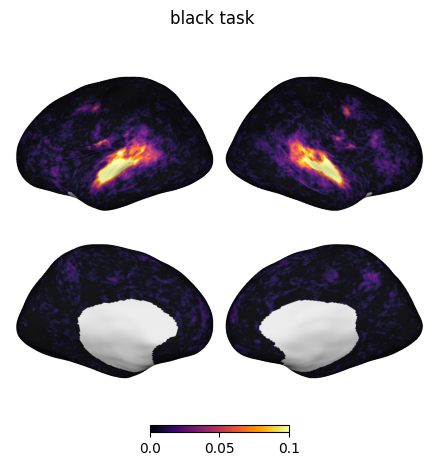

In [16]:
plot.surface_plot(avg_tsk_scores, surf_lh_fn=None, surf_rh_fn=None, title=f'{narrative} task', vmin=0, vmax=0.1, cmap='inferno');

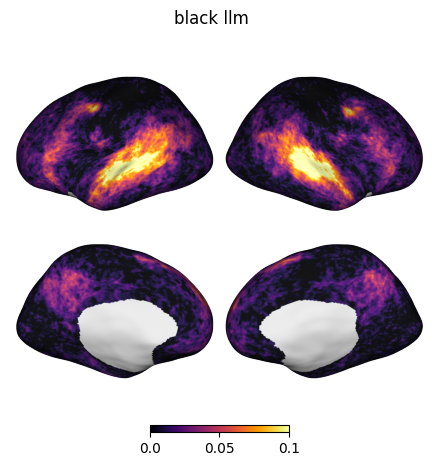

In [18]:
plot.surface_plot(avg_llm_scores, surf_lh_fn=None, surf_rh_fn=None, title=f'{narrative} llm', vmin=0, vmax=0.1, cmap='inferno');

# grouped subject, 2 fold

In [25]:
filename = f'encoding_group_2fold/{narrative}/sub-000/model-gemma-2b_layer-{layer}/sub-000.h5'
with h5py.File(filename, 'r') as f:
    cv_scores = f['cv_scores'][...]

In [26]:
grp_task_scores = cv_scores[:, 0].mean(0)
grp_llms_scores = cv_scores[:, 1].mean(0)

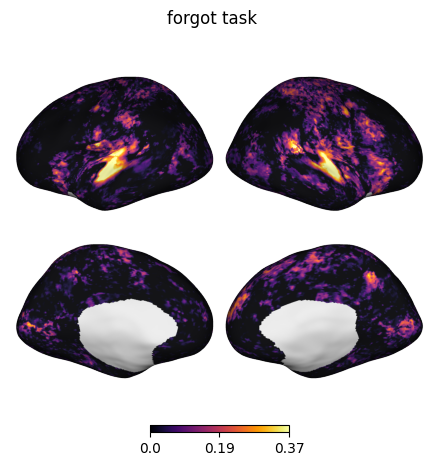

In [27]:
plot.surface_plot(grp_task_scores, surf_lh_fn=None, surf_rh_fn=None, title=f'{narrative} task', vmin=0, cmap='inferno');

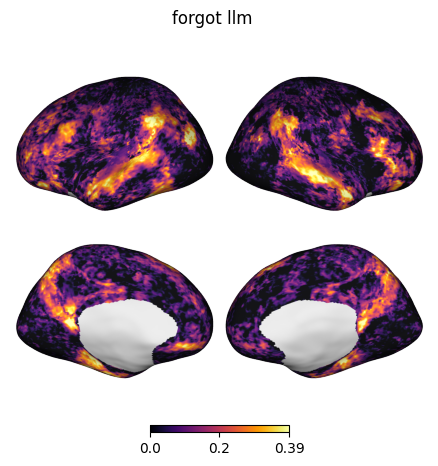

In [28]:
plot.surface_plot(grp_llms_scores, surf_lh_fn=None, surf_rh_fn=None, title=f'{narrative} llm', vmin=0, cmap='inferno');

# within subject, across-story test

In [37]:
files = glob.glob(f'encoding/black/sub-*/model-gemma-2b_layer-{layer}/*h5')

scores_black = []
scores_forgot = []
for filename in files:
    with h5py.File(filename, 'r') as f:
        scores_black.append(f['scores1'][...])
        scores_forgot.append(f['scores2'][...])
scores_black = np.stack(scores_black)
scores_forgot = np.stack(scores_forgot)
scores_black.shape

(46, 2, 81924)

In [39]:
avg_scores_black = scores_black[:, 1].mean(0)
avg_scores_forgot = scores_forgot[:, 1].mean(0)

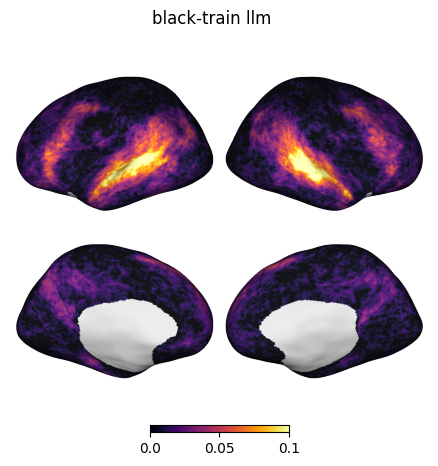

In [46]:
plot.surface_plot(avg_scores_black, surf_lh_fn=None, surf_rh_fn=None, title='black-train llm', vmin=0, vmax=0.1, cmap='inferno');

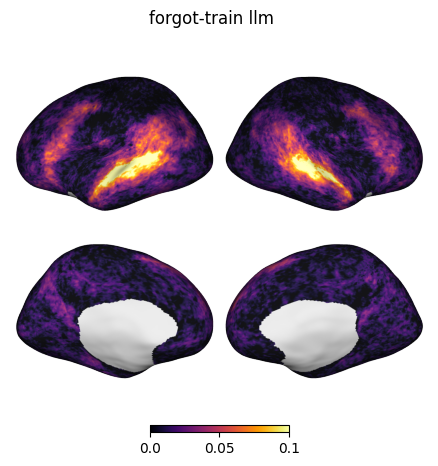

In [47]:
plot.surface_plot(avg_scores_forgot, surf_lh_fn=None, surf_rh_fn=None, title='forgot-train llm', vmin=0, vmax=0.1, cmap='inferno');

# grouped subject, across-story test

In [32]:
filename = f'encoding_group/black/sub-000/model-gemma-2b_layer-{layer}/sub-000.h5'
with h5py.File(filename, 'r') as f:
    print(f.keys())
    scores_black = f['scores1'][...]
    scores_forgot = f['scores2'][...]

<KeysViewHDF5 ['actual1', 'actual2', 'preds1', 'preds2', 'scores1', 'scores2']>


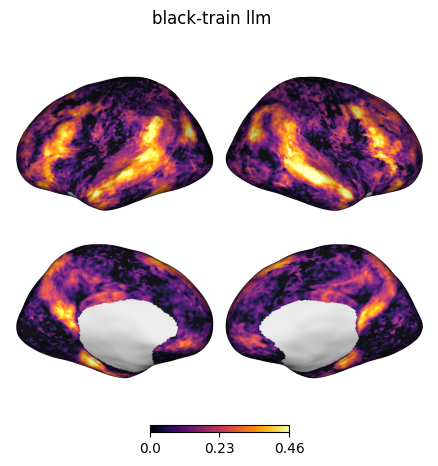

In [35]:
plot.surface_plot(scores_black[1], surf_lh_fn=None, surf_rh_fn=None, title='black-train llm', vmin=0, cmap='inferno');

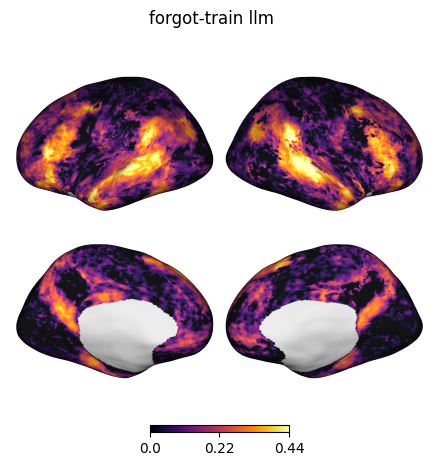

In [36]:
plot.surface_plot(scores_forgot[1], surf_lh_fn=None, surf_rh_fn=None, title='forgot-train llm', vmin=0, cmap='inferno');